Import Libraries

In [2]:
from scipy.io import loadmat
from scipy.signal import find_peaks
import numpy as np
from pathlib import Path
from typing import List, Tuple
import pickle
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import numpy as np
import sys
from sklearn.metrics import mean_squared_error
import csv
import pandas as pd
import os

Pre-Process Data

In [3]:
"""
A function to extract chunks of data from .mat files.

Args:
filenames (List[str]): A list of file paths to .mat files to extract data from.

Returns:
List[Tuple[np.ndarray, np.ndarray]]: A list of tuples, where each tuple contains two NumPy ndarrays. 
The first ndarray is a chunk of data from the X variable of the .mat file, 
and the second ndarray is a chunk of data from the Y variable of the .mat file. 
The chunks are determined by finding peaks in the Y data and dividing the data into segments between the peaks.

Note:
This function requires the NumPy and SciPy libraries to be installed.
"""
def extract_mat_file_chunks(filenames: List[str]) -> List[Tuple[np.ndarray, np.ndarray]]:
    mat_data = [loadmat(filename) for filename in filenames]
    xs, ys = zip(*[(data["X"].T[:, :3], data["Y"].T) for data in mat_data])
    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0)

    diff = ys[1:, 0] - ys[:-1, 0]
    peaks, _ = find_peaks(diff, height=0.5) # finds peaks in y that are above 0.99, and have a distance of at least 500

    x_chunks = []
    y_chunks = []
    start = -1
    for i in peaks:
        x_chunks.append(xs[start+1:i])
        y_chunks.append(ys[start+1:i])
        start = i
    x_chunks.append(xs[start+1:])
    y_chunks.append(ys[start+1:])

    return list(zip(x_chunks, y_chunks))

In [4]:
#same as extract_mat_file_chunks but for a single csv file
def extract_csv_file_chunks(filename: str) -> List[Tuple[np.ndarray, np.ndarray]]:
    
    #opens the csv file 
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        data = list(reader)

    # removes the first row and converts the data to a numpy array
    data.pop(0)
    data = np.array(data, dtype=float)

    #splits the data into x (last 3 columns) and y (first column)
    x = data[:, 3:]
    y = data[:, 0]

    #finds the peaks in the y data (the peaks are the times when the SOC changes more than 10% in 1 second)
    diff = abs(y[1:] - y[:-1])
    # finds peaks in y that are above 0.99, and have a distance of at least 500
    peaks, _ = find_peaks(diff,height=50)

    #splits the data into chunks based on the peaks
    x_chunks = []
    y_chunks = []

    start = -1
    for i in peaks:
        x_chunks.append(x[start+1:i])
        y_chunks.append(y[start+1:i])
        start = i

    x_chunks.append(x[start+1:])
    y_chunks.append(y[start+1:])

    #plots the Y with the peaks marked
    plt.plot(y)
    plt.plot(peaks, y[peaks], "x")
    plt.plot(np.zeros_like(y), "--", color="gray")
    plt.show()

    return list(zip(x_chunks, y_chunks))


In [30]:
# does the same as extract_csv_file_chunks but for excel files
def extract_excel_file_chunks(excel_files: str) -> List[Tuple[np.ndarray, np.ndarray]]:

    #reads all excel files in the folder
    x_chunks = []
    y_chunks = []
    for excel_file in excel_files:
        df = pd.read_excel("Data/philcar/"+excel_file, sheet_name=None)        

        soc = []
        v = []
        i = []
        t = []

        for sheet in df:
            if 'HV Battery SOC [%]' in df[sheet].columns:
                soc = df[sheet]['HV Battery SOC [%]']
            if 'HV Battery Voltage [V]' in df[sheet].columns:
                v = df[sheet]['HV Battery Voltage [V]']
            if 'HV Battery Current [A]' in df[sheet].columns:
                i = df[sheet]['HV Battery Current [A]']
            if 'OAT [degC]' in df[sheet].columns:
                t = df[sheet]['OAT [degC]']
        
        # ensures that all columns are found
        if len(soc) == 0 or len(v) == 0 or len(i) == 0 or len(t) == 0:
            print('Error: NaN value in file ' + excel_file)
            continue
        else:
            print('Found all columns in file ' + excel_file)

            # iterate through the lists and write the data to the chunks
            x_chunk = []
            y_chunk = []
            for x in range(len(soc)):
                # double check that the data is not NaN
                if soc[x] == soc[x] and v[x] == v[x] and i[x] == i[x] and t[x] == t[x]:
                    x_chunk.append([v[x], i[x], t[x]])
                    y_chunk.append([soc[x]])

            # convert the lists to numpy arrays
            x_chunk = np.array(x_chunk)
            y_chunk = np.array(y_chunk)


            x_chunks.append(x_chunk)
            y_chunks.append(y_chunk)

    return list(zip(x_chunks, y_chunks))

In [31]:
#mat_files = list(Path(".").glob("*.mat"))
#mat_files.sort()

# grabs all the excel files from the parent directory in folder Data/philcar
excel_files = [f for f in os.listdir('Data/philcar') if f.endswith('.xlsx')]
excel_files.sort()

all_chunks = extract_excel_file_chunks(excel_files)


Found all columns in file Phil_DC_63_14degC.xlsx
Found all columns in file Phil_DC_58_17degC.xlsx
Found all columns in file Phil_DC_56_26degC.xlsx
Found all columns in file Phil_DC_21_6degC.xlsx
Found all columns in file Phil_DC_74_-4degC.xlsx
Found all columns in file Phil_DC_92_16degC.xlsx
Found all columns in file Phil_DC_38_19degC.xlsx
Found all columns in file Phil_DC_71_4degC.xlsx
Found all columns in file Phil_DC_089_14degC.xlsx
Found all columns in file Phil_DC_28_9degC.xlsx
Found all columns in file Phil_DC_64_9degC.xlsx
Found all columns in file Phil_DC_50_29degC.xlsx
Found all columns in file Phil_DC_43_26degC.xlsx
Found all columns in file Phil_DC_47_28degC.xlsx
Found all columns in file Phil_DC_75_1degC.xlsx
Found all columns in file Phil_DC_6_24degC.xlsx
Found all columns in file Phil_DC_49_27degC.xlsx
Found all columns in file Phil_DC_053_25degC.xlsx
Found all columns in file Phil_DC_11_-3degC.xlsx
Found all columns in file Phil_DC_9_3degC.xlsx
Found all columns in file 

In [32]:
print(type(all_chunks))
#print the type of x and y in the first chunk
print(type(all_chunks[0][0]))
print(type(all_chunks[0][1]))
print(len(all_chunks))


<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
93


In [38]:
# smoothen each chunk using a moving average
for i in range(len(all_chunks)):
    #print(all_chunks[i][0].shape)
    all_chunks[i] = all_chunks[i].rolling(100).mean()

AttributeError: 'tuple' object has no attribute 'rolling'

Calculate Values for Standardizing Data


In [33]:
means, stds = zip(*[(x.mean(axis=0), x.std(axis=0)) for (x, _) in all_chunks])
means = np.array(means).mean(axis=0)
stds = np.array(stds).mean(axis=0)
print(means.shape)
print(stds.shape)

(3,)
(3,)


Definine NN Architecture

In [34]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden_size = 16  
        self.num_layers = 1

        # Define the LSTM layer with input size 3, output size 16, and 1 layer.
        # Set batch_first to True so that the input tensor has shape (batch_size, seq_length, input_size)
        self.lstm = nn.LSTM(3, 16, 1, batch_first=True) 

        self.ln = nn.LayerNorm(16)

        # Define the fully connected layer with a dropout of 0.2 and output size of 1
        self.fc1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(16, 1),
        )
        
    def forward(self, x):
        # Pass the input tensor x to the LSTM layer
        out = x
        out, _ = self.lstm(out)
        
        # Apply layer normalization to the output of the LSTM layer
        out = self.ln(out)

        # Pass the output through the fully connected layer with dropout and clipping the output between 0 and 1
        out = self.fc1(out)
        out = torch.clip(out, 0, 1)
        
        return out

In [35]:
# Instantiate the LSTM model and move it to the GPU
model = LSTMModel().cuda()

# Define the mean squared error loss function
criterion = nn.MSELoss()

# Define the AdamW optimizer with a learning rate of 0.01 and optimize the model parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

Train Model

In [37]:
# Sets model to training mode
model.train()

# 200 Epochs
for i in range(100): 
    loss = 0
    for (inputs, targets) in all_chunks:
        # Convert inputs and targets to tensors, normalize the inputs, and move them to the GPU
        inputs = torch.from_numpy((inputs - means) / stds).float().unsqueeze(0).cuda()
        targets = torch.from_numpy(targets).float().unsqueeze(0).cuda()

        # Forward pass through the model
        outputs = model(inputs)

        # Compute the loss and add it to the running total
        loss += criterion(outputs, targets) ** 0.5
    loss /= len(all_chunks)

    # Compute the loss and add it to the running total
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())

70.08534240722656
69.86428833007812
69.67683410644531
69.53876495361328
69.448974609375
69.40171813964844
69.3731918334961
69.35049438476562
69.32368469238281
69.30694580078125
69.30330657958984
69.30252075195312
69.30226135253906
69.30216217041016
69.30206298828125
69.30204772949219
69.30198669433594
69.30198669433594
69.30194854736328
69.30194091796875
69.30191802978516
69.30193328857422
69.3018798828125
69.30191040039062
69.30189514160156
69.30186462402344
69.30189514160156
69.30186462402344
69.3018569946289
69.30186462402344
69.3018798828125
69.30186462402344
69.30186462402344
69.3018569946289
69.30184173583984
69.30187225341797
69.30184173583984
69.30183410644531
69.30181884765625
69.30184173583984
69.30182647705078
69.30183410644531
69.30182647705078
69.30181884765625
69.30184173583984
69.30182647705078
69.30184173583984
69.30181884765625
69.30183410644531
69.30181121826172
69.30181121826172
69.30181121826172
69.3018569946289
69.30181884765625
69.30182647705078
69.30181884765625


Evaluate Model

In [39]:
# Sets model to training mode
model.eval()

# Turn off gradient tracking during inference
with torch.no_grad():
    losses = []
    for (inputs, targets) in all_chunks:
        # Convert the inputs and targets into tensors and move them to GPU
        inputs = torch.from_numpy((inputs - means) / stds).float().unsqueeze(0).cuda()
        targets = torch.from_numpy(targets).float().unsqueeze(0).cuda()
        
        # Forward Pass
        outputs = model(inputs)

        # Calculate the RMSE loss between the predicted outputs and the targets
        loss = criterion(outputs, targets) ** 0.5
        
        print(f'Loss: {loss.item():.4f}')
        losses.append(loss.item())
    print(sum(losses) / len(losses))

Loss: 94.1782
Loss: 56.4508
Loss: 67.0607
Loss: 84.4410
Loss: 77.7899
Loss: 57.9204
Loss: 34.0776
Loss: 62.9299
Loss: 85.6292
Loss: 87.1146
Loss: 90.6492
Loss: 91.9748
Loss: 90.2799
Loss: 57.4728
Loss: 56.9238
Loss: 85.4340
Loss: 88.7096
Loss: 65.3074
Loss: 75.2645
Loss: 64.0629
Loss: 87.0748
Loss: 35.9711
Loss: 88.7513
Loss: 32.2316
Loss: 83.1476
Loss: 89.4878
Loss: 90.5189
Loss: 93.1559
Loss: 91.8979
Loss: 90.0666
Loss: 45.0947
Loss: 66.6276
Loss: 78.8002
Loss: 91.5944
Loss: 90.8469
Loss: 81.6850
Loss: 79.1099
Loss: 53.8498
Loss: 34.2941
Loss: 28.4391
Loss: 88.9538
Loss: 59.2374
Loss: 48.4023
Loss: 87.6091
Loss: 86.6632
Loss: 32.4506
Loss: 38.6567
Loss: 83.1302
Loss: 92.5498
Loss: 46.9529
Loss: 37.2731
Loss: 33.5614
Loss: 73.1391
Loss: 83.5448
Loss: 86.9474
Loss: 58.8648
Loss: 86.0955
Loss: 82.8860
Loss: 39.1382
Loss: 90.9964
Loss: 88.1567
Loss: 68.4011
Loss: 55.8660
Loss: 40.6200
Loss: 92.4463
Loss: 40.9300
Loss: 91.6552
Loss: 88.2384
Loss: 43.0820
Loss: 36.8260
Loss: 54.2065
Loss: 

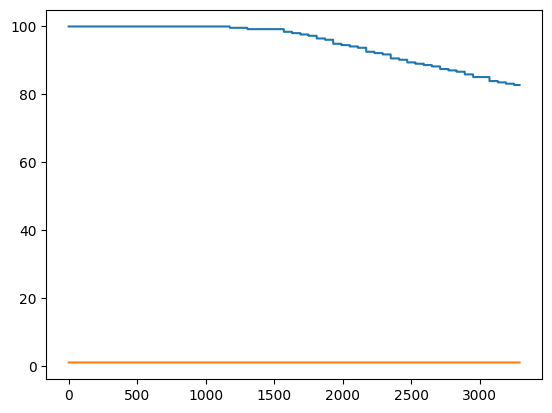

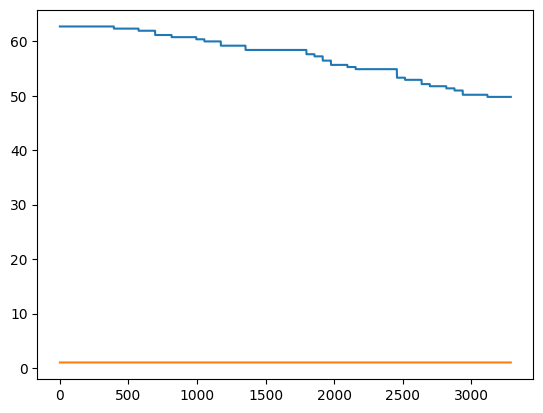

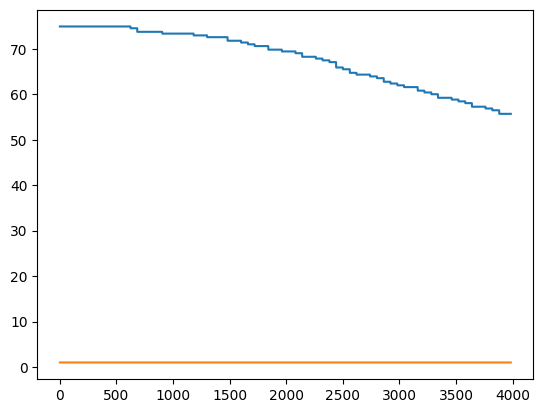

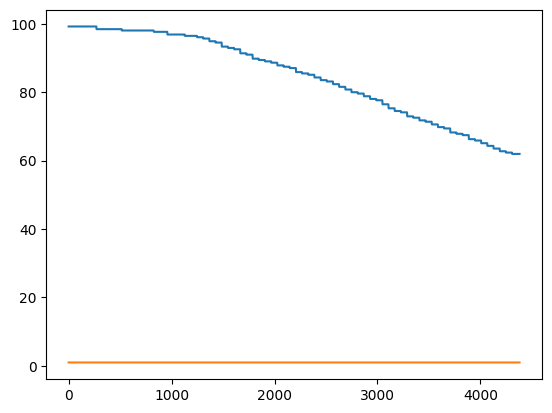

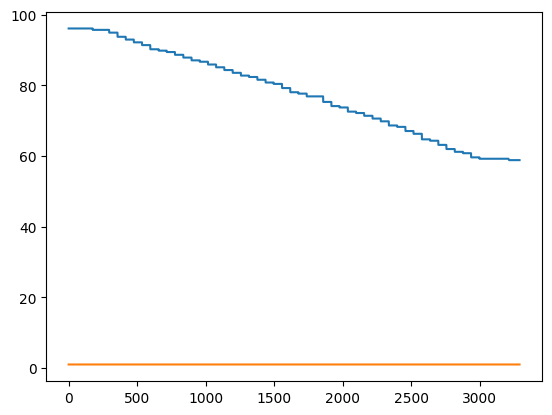

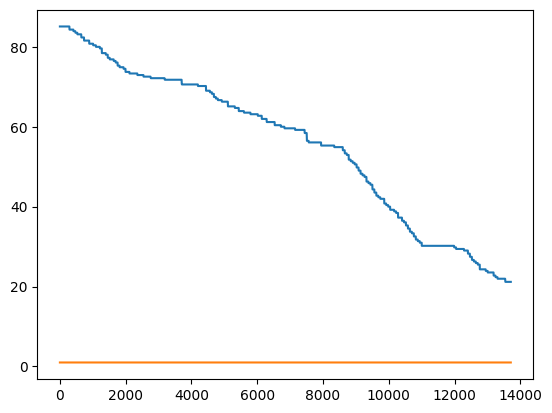

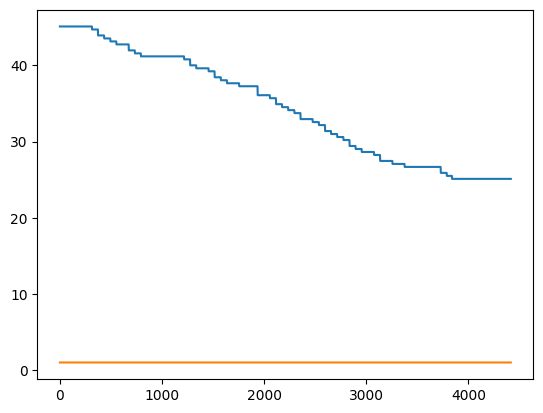

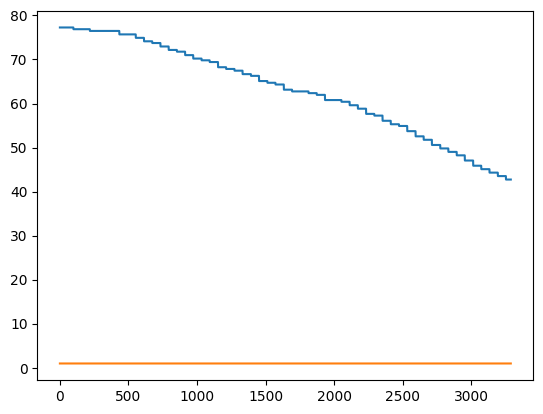

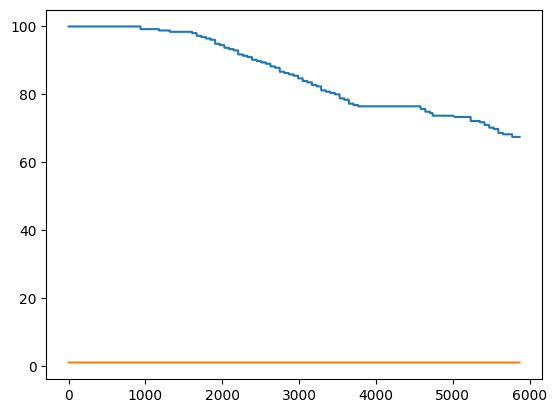

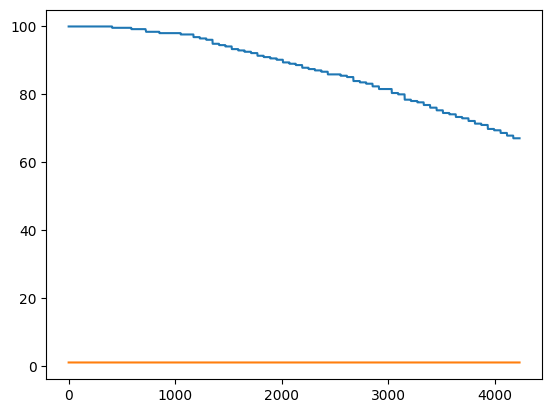

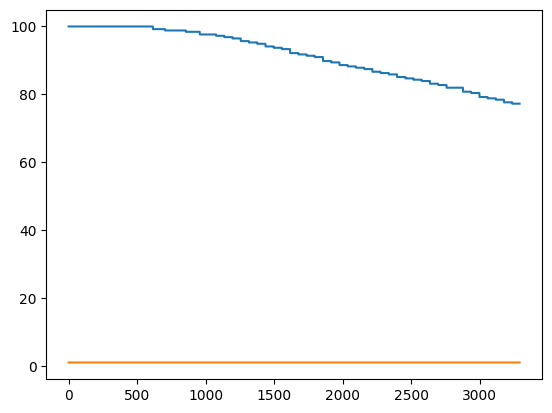

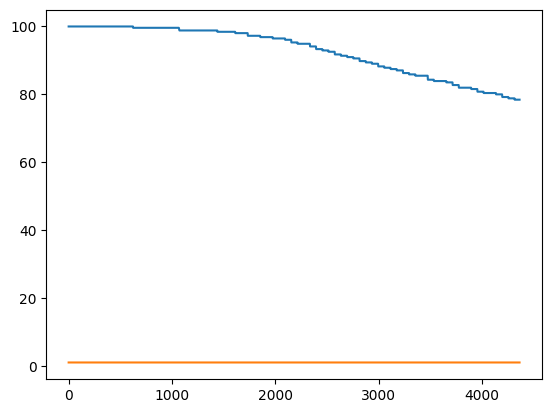

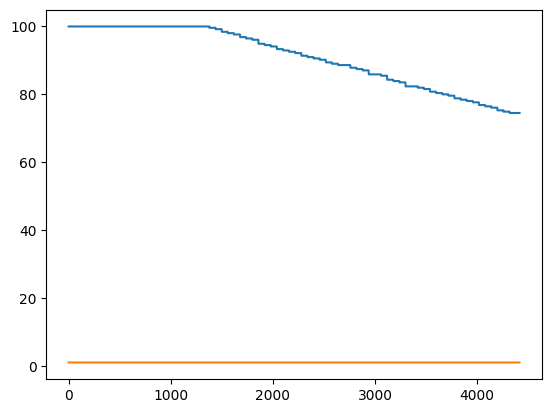

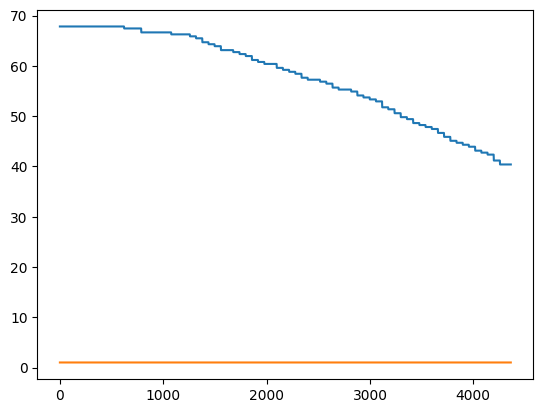

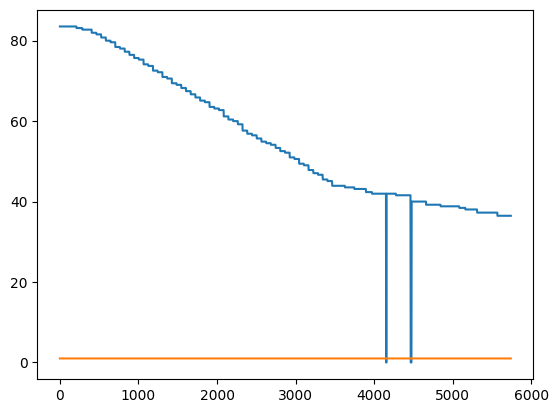

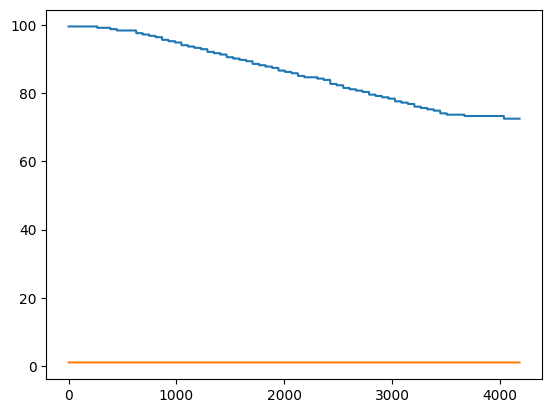

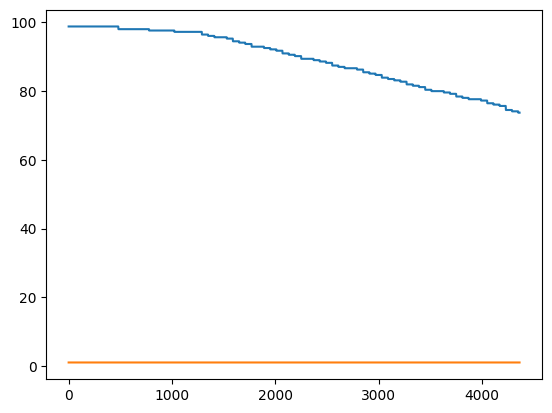

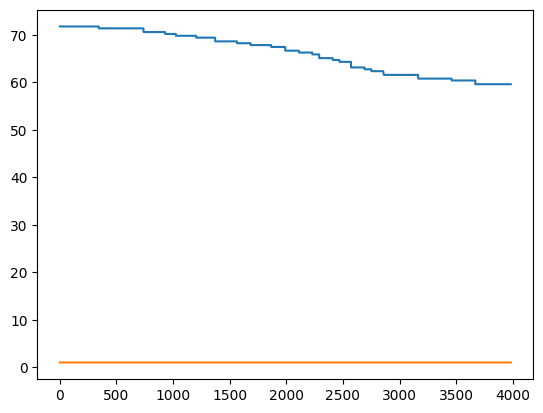

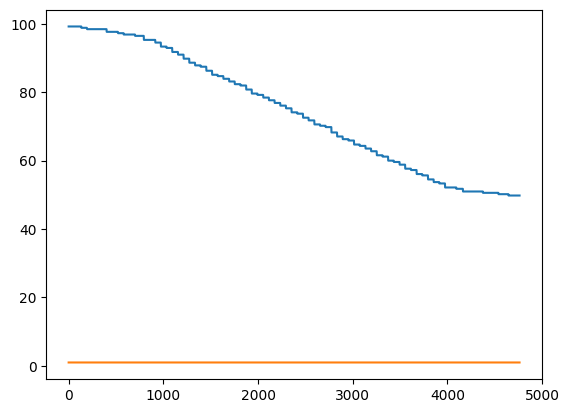

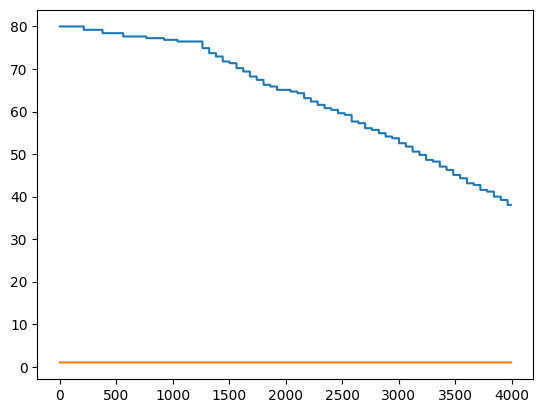

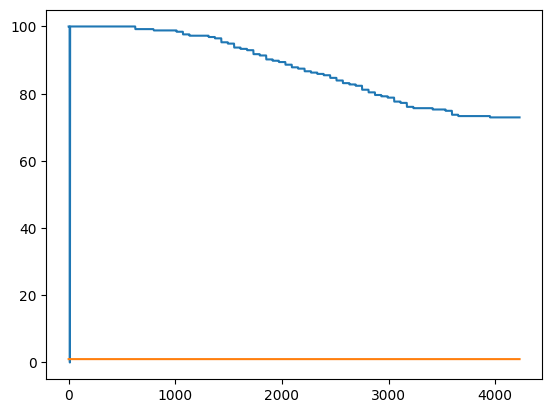

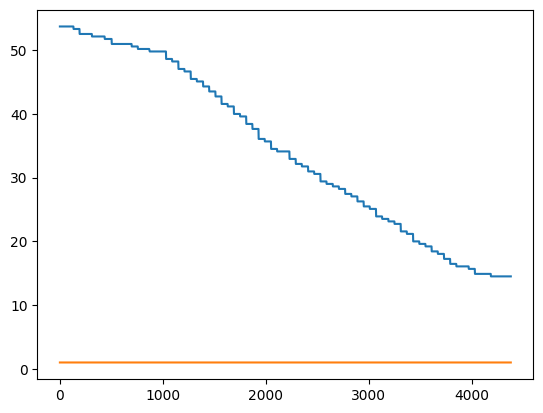

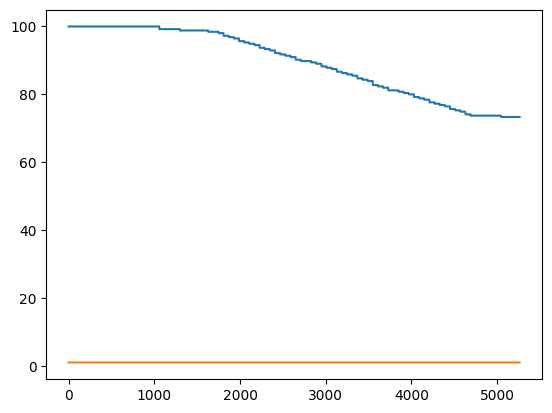

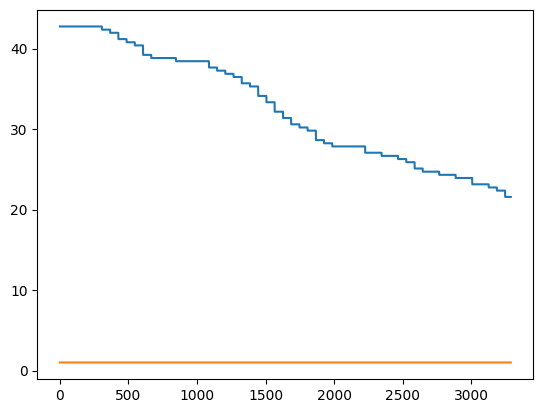

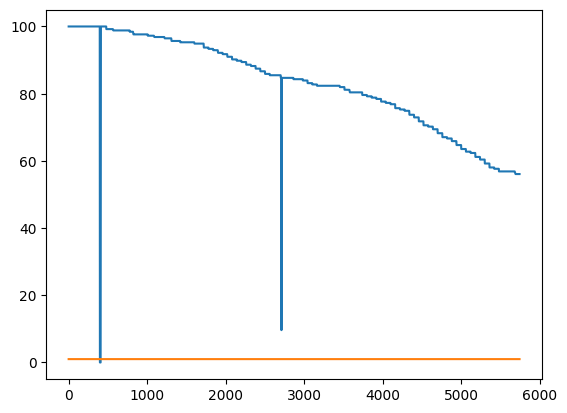

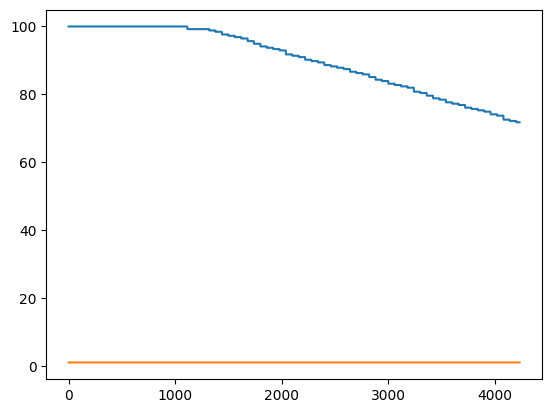

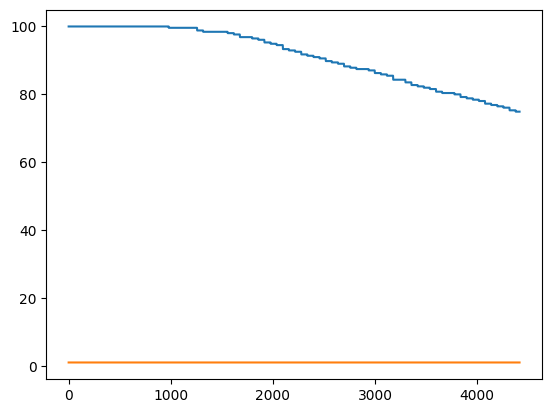

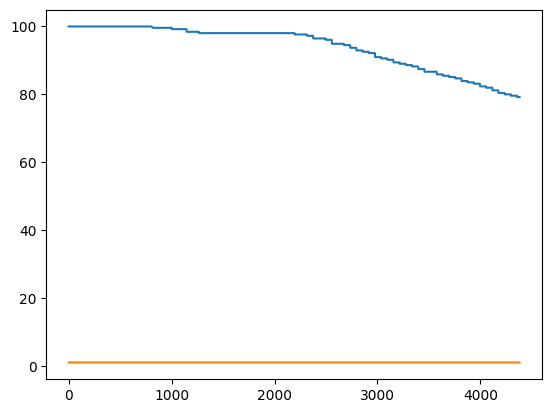

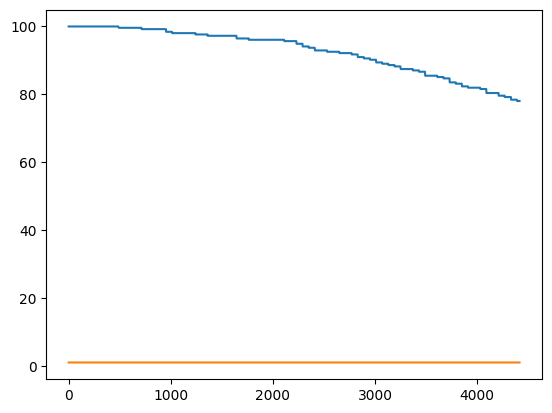

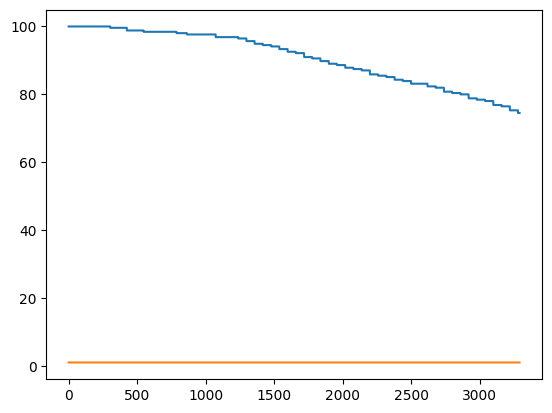

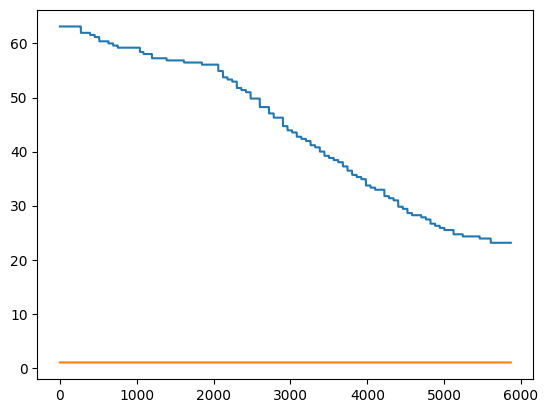

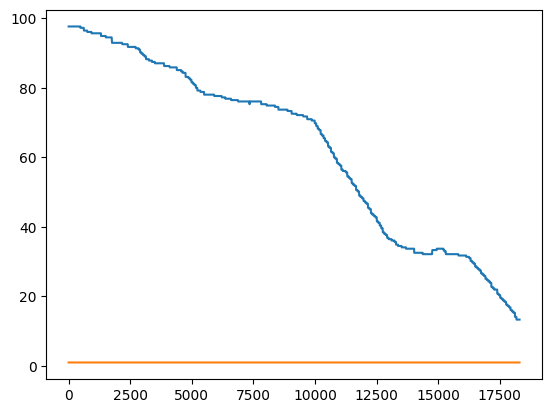

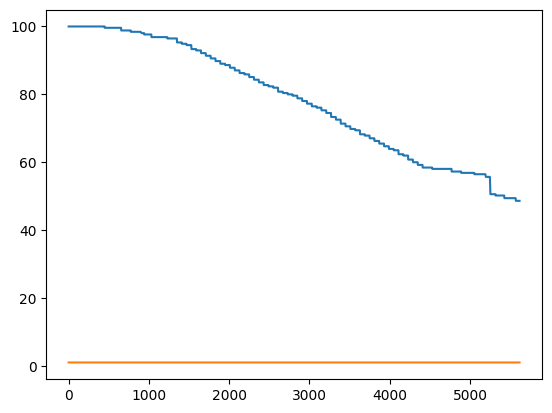

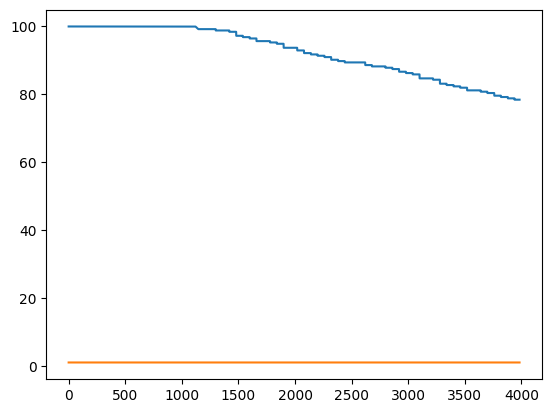

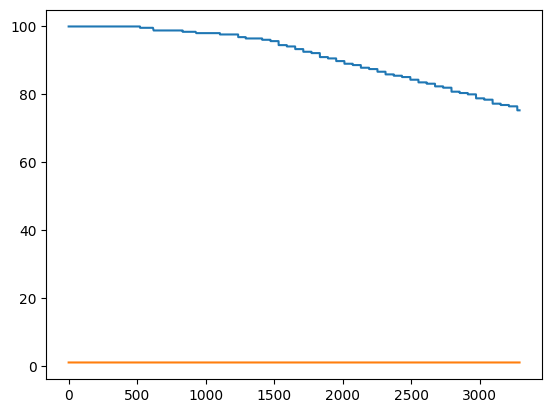

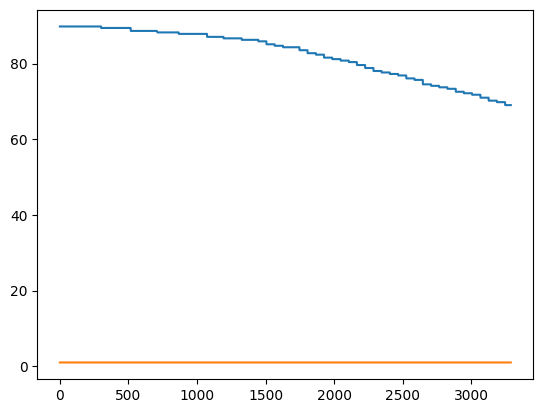

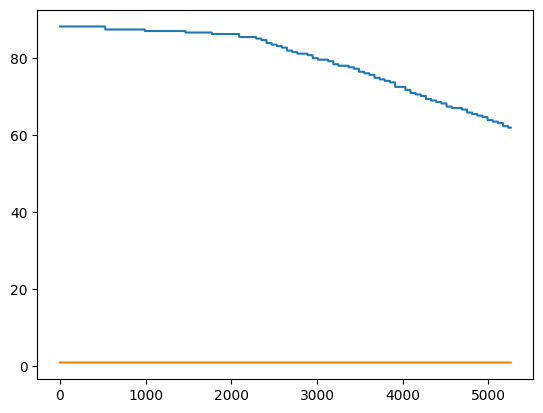

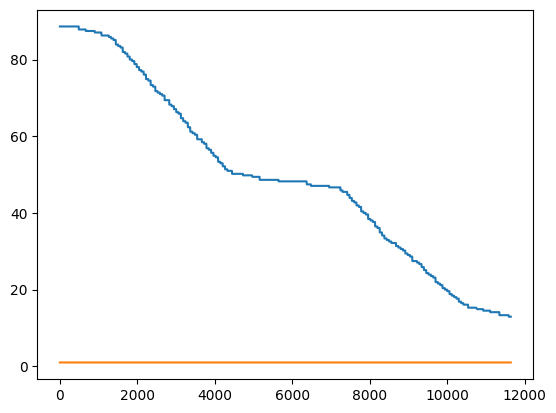

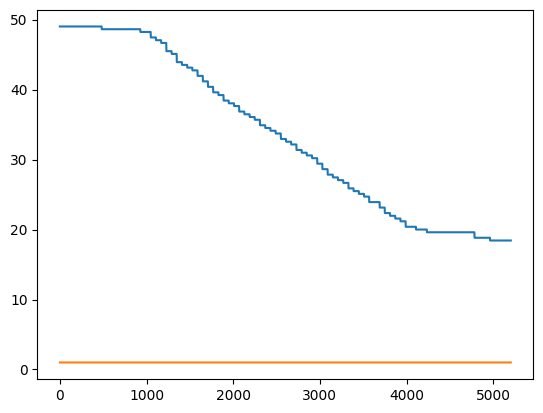

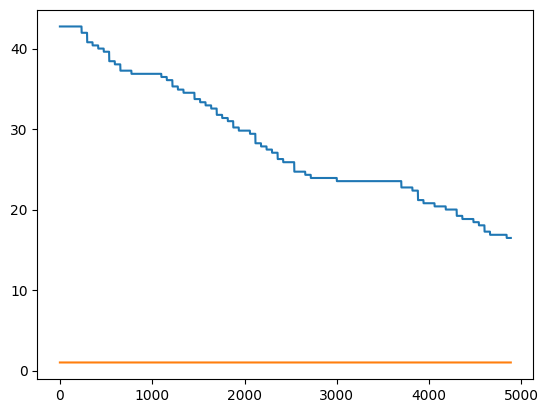

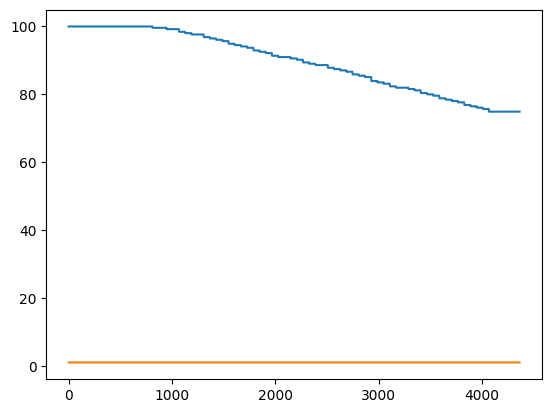

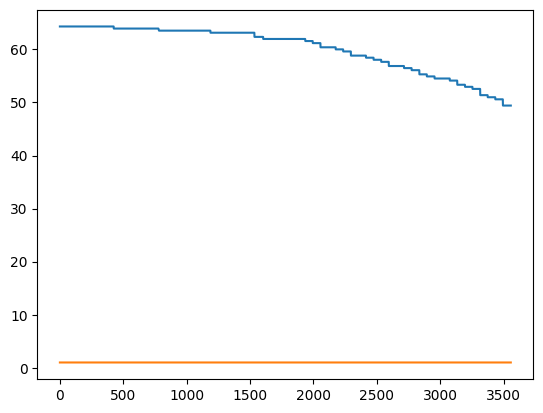

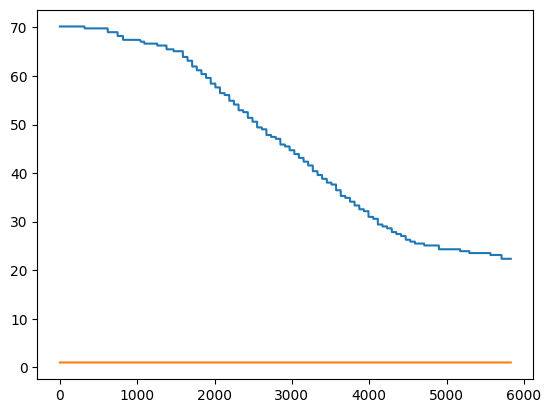

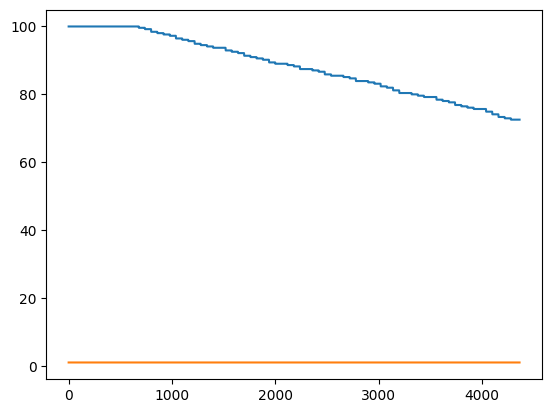

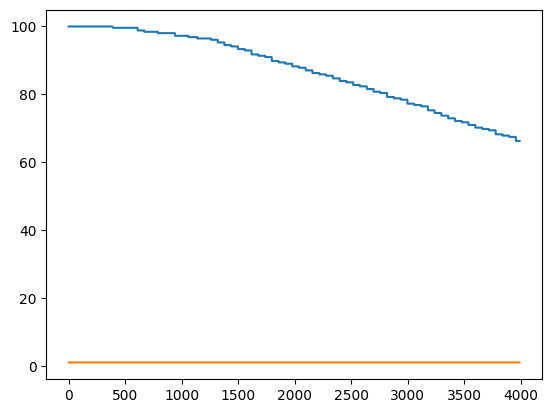

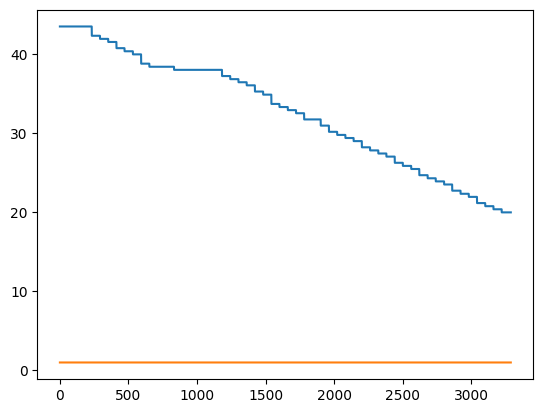

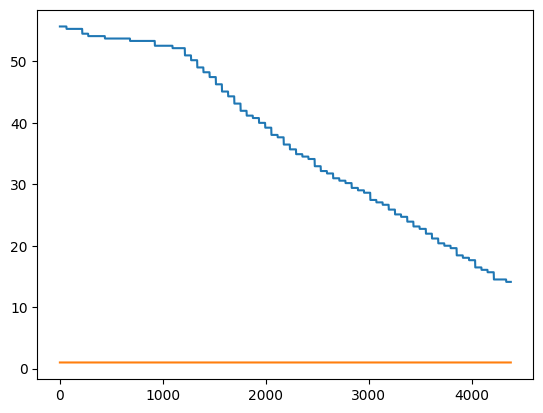

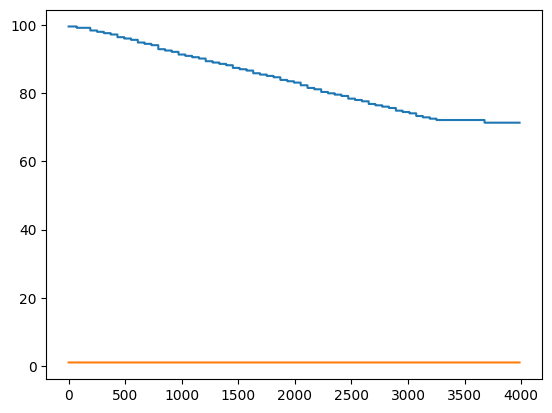

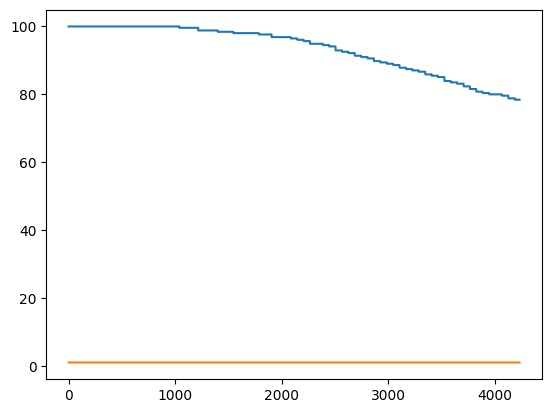

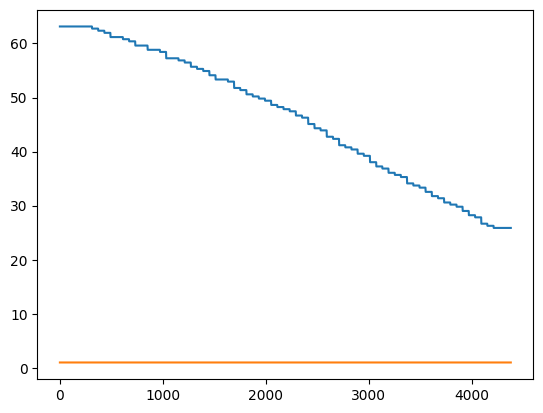

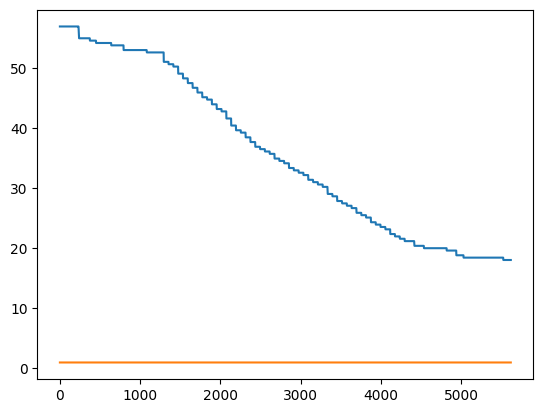

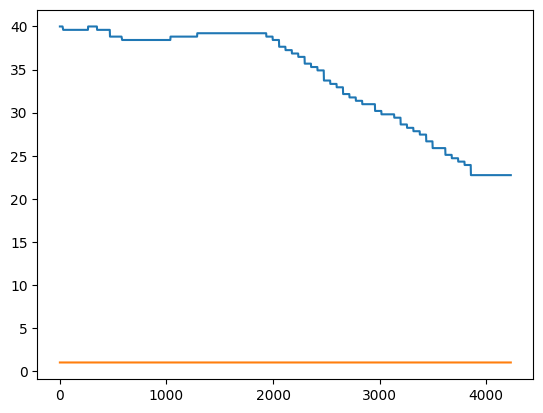

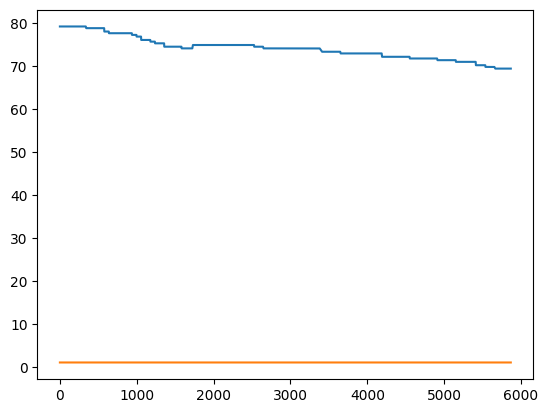

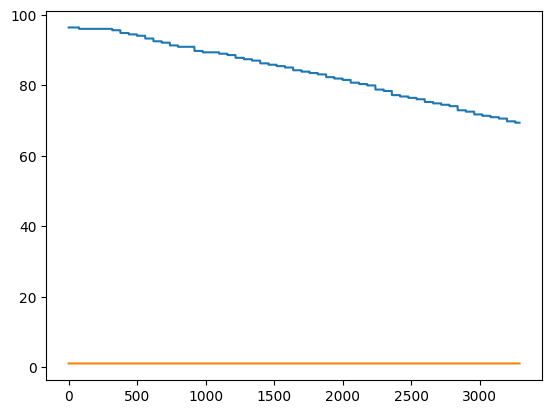

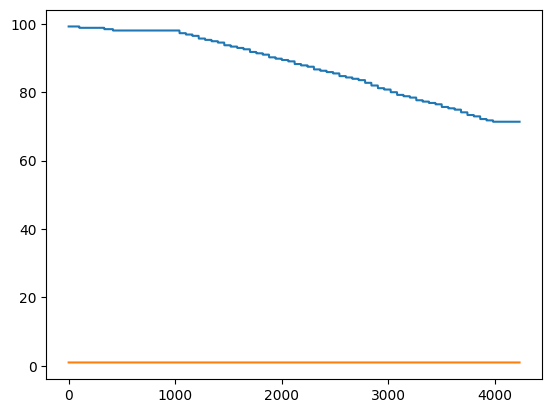

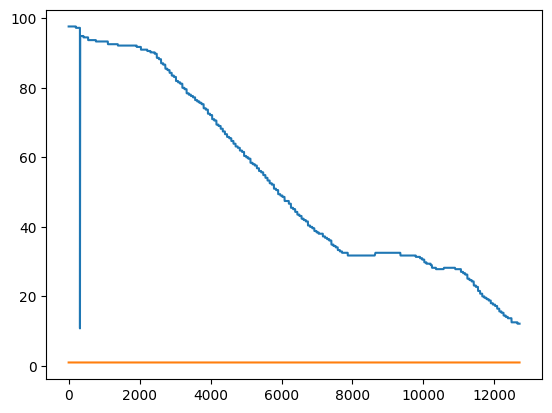

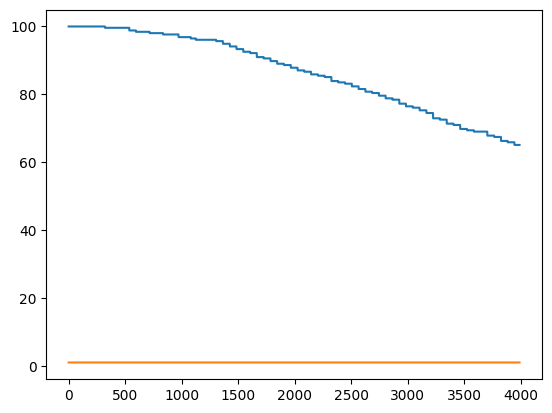

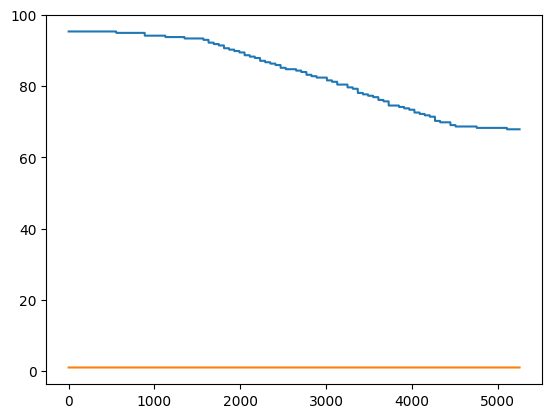

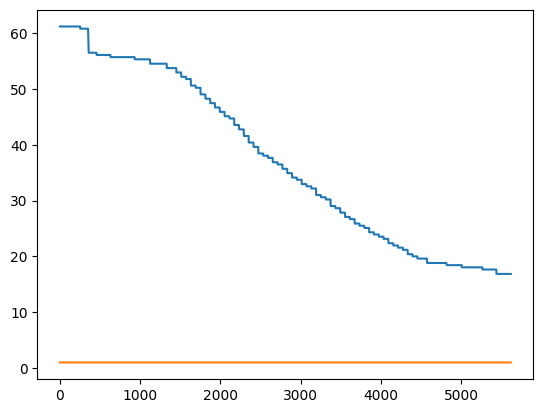

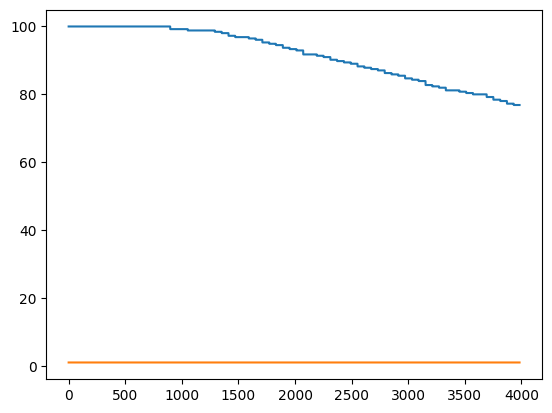

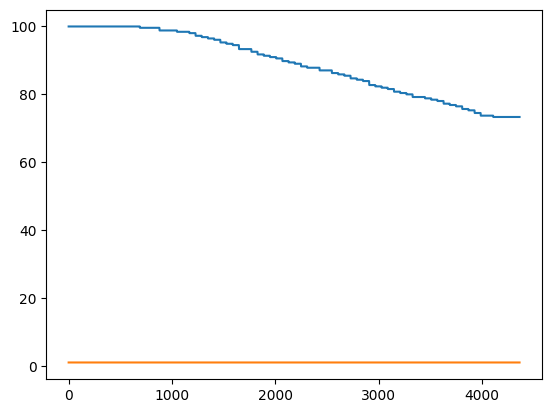

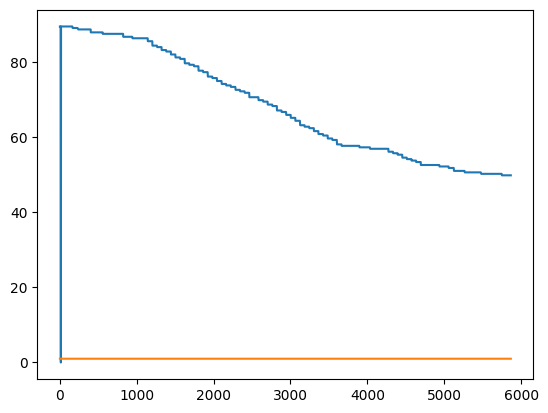

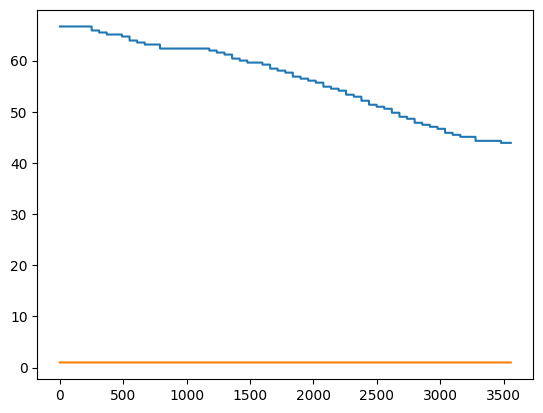

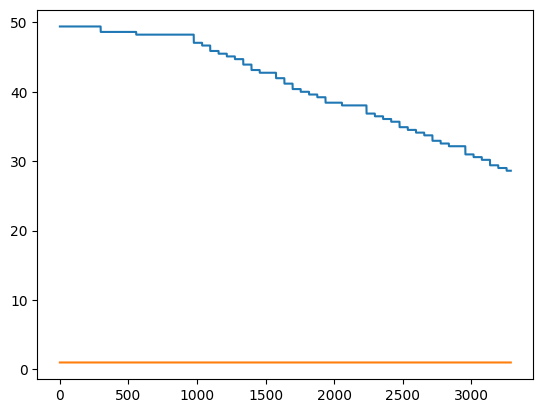

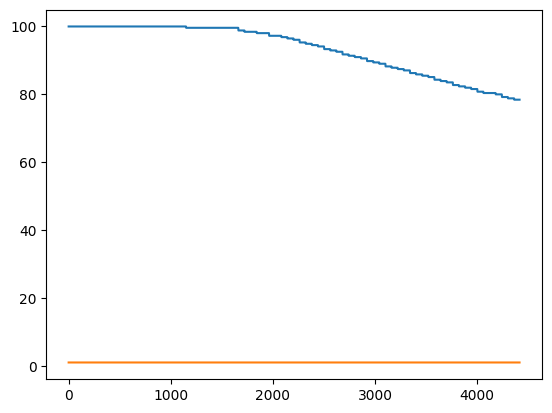

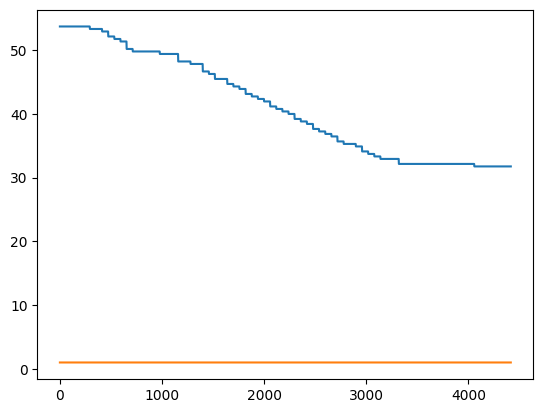

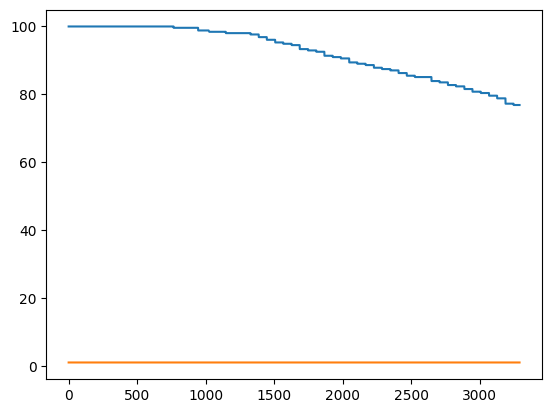

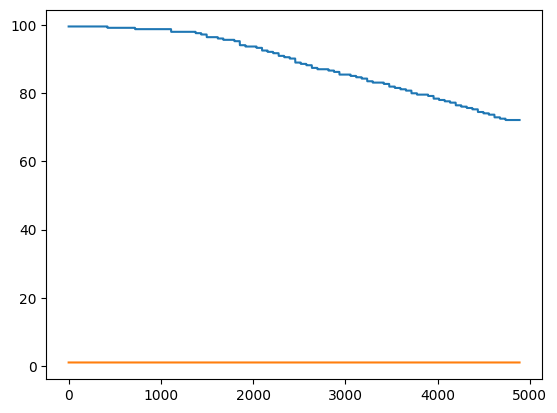

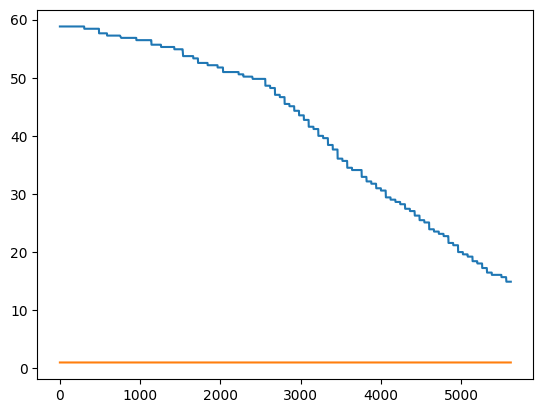

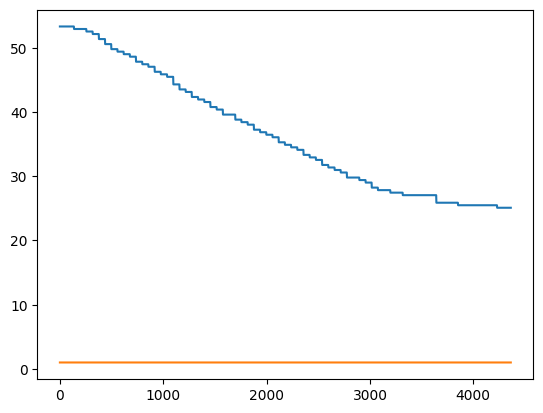

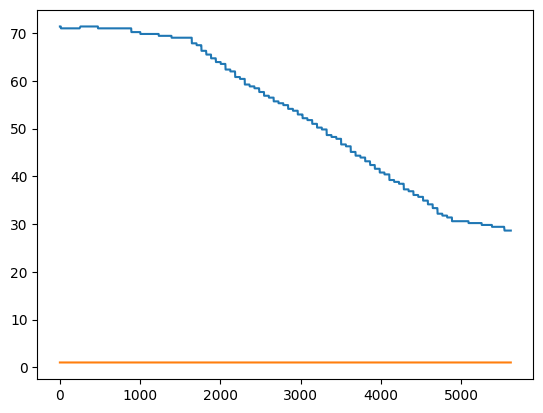

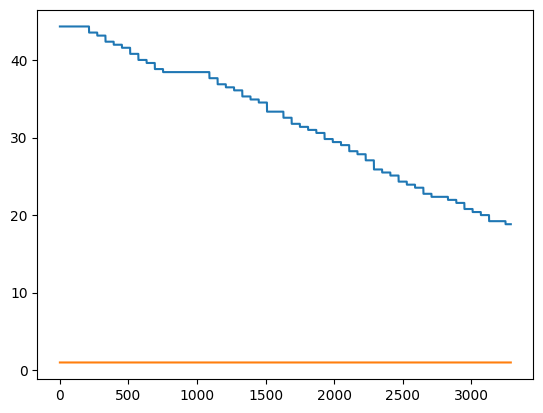

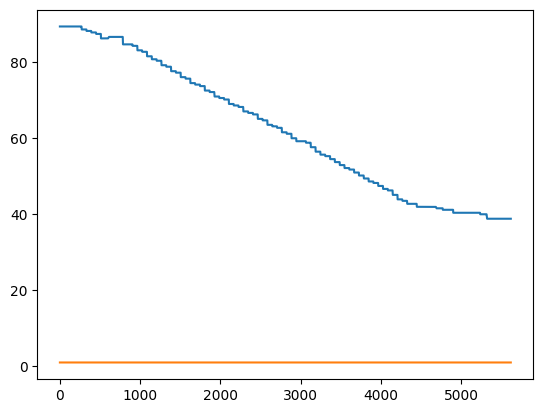

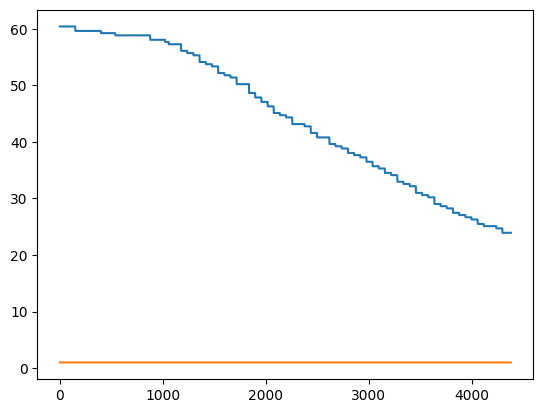

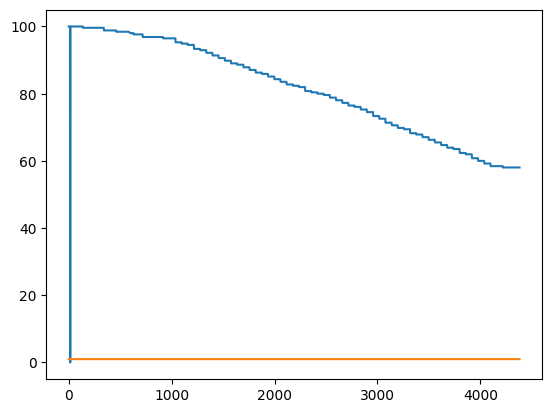

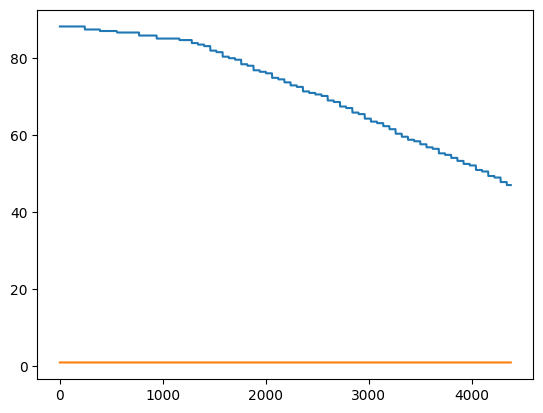

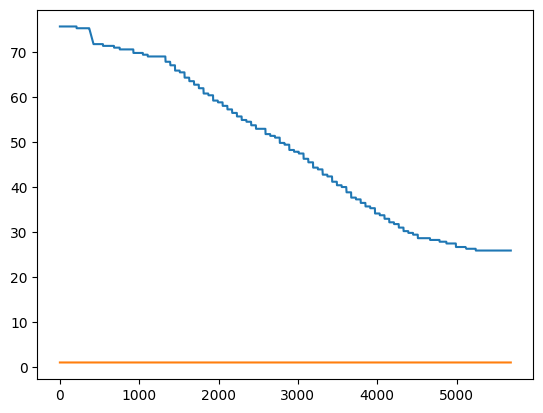

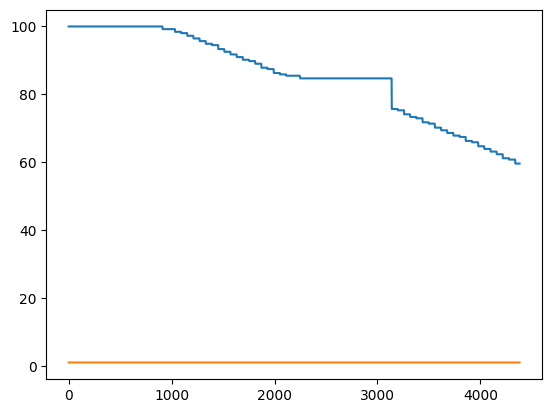

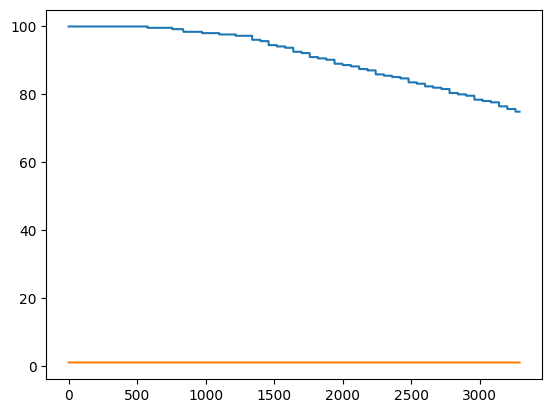

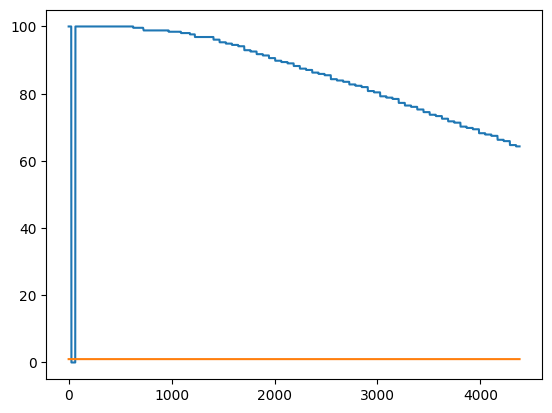

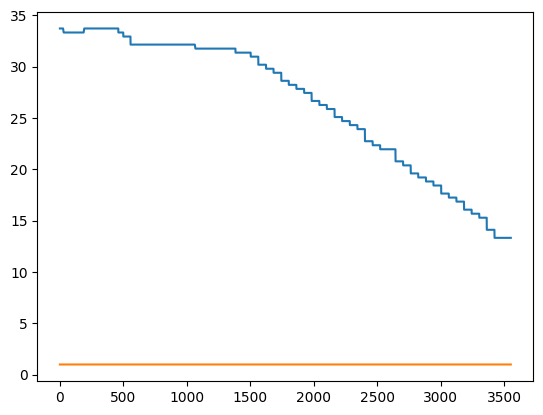

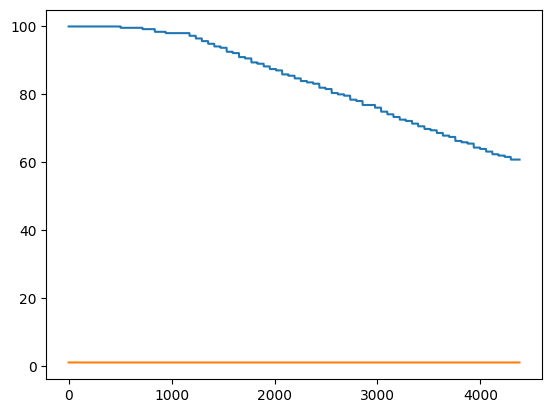

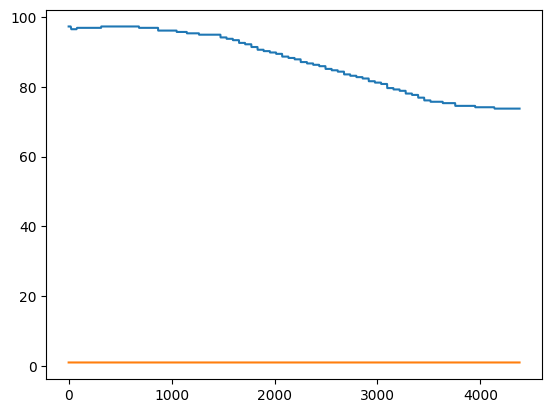

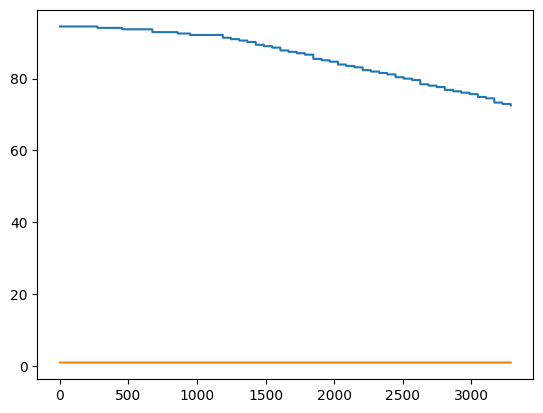

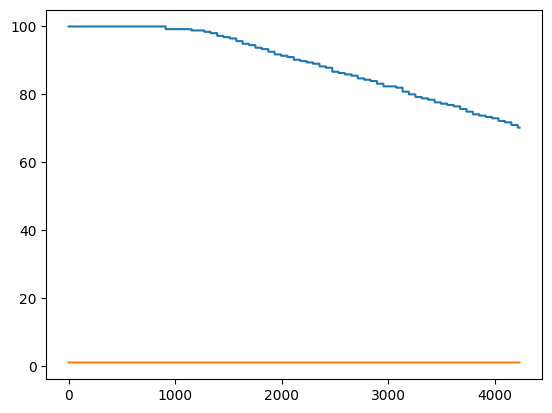

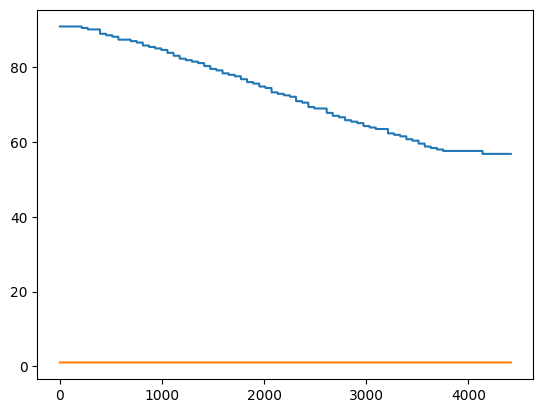

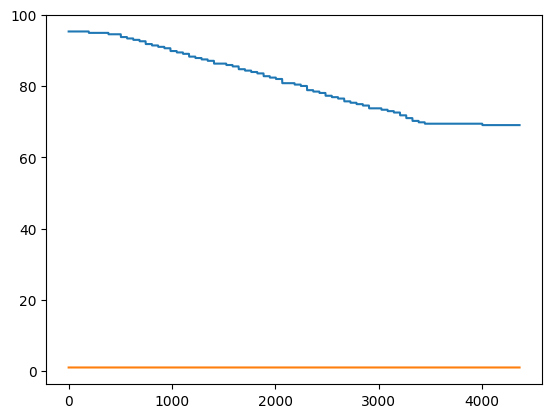

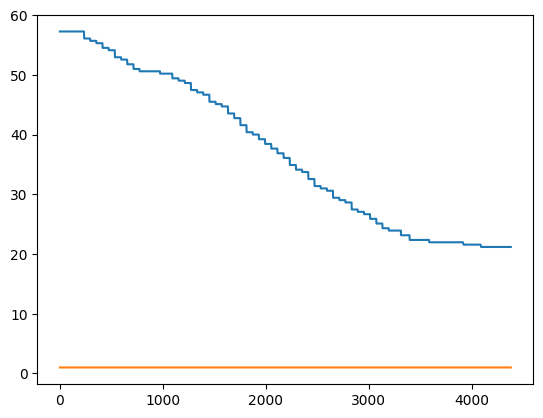

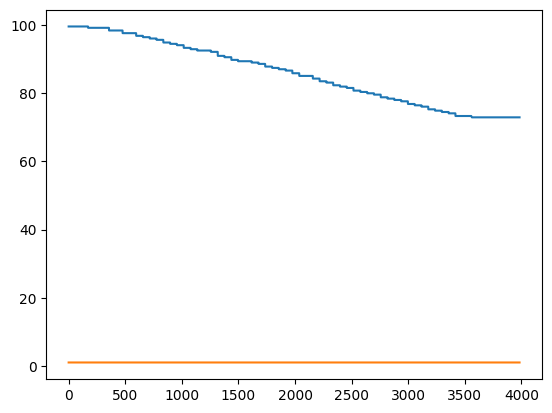

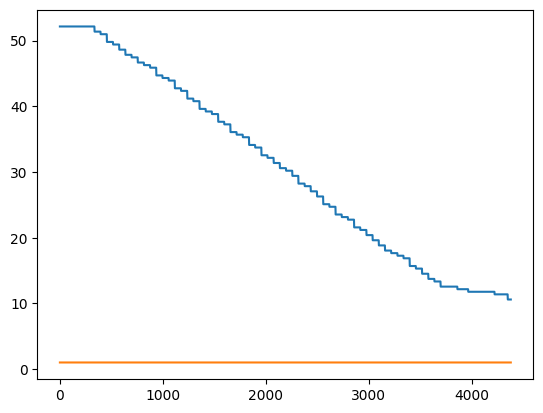

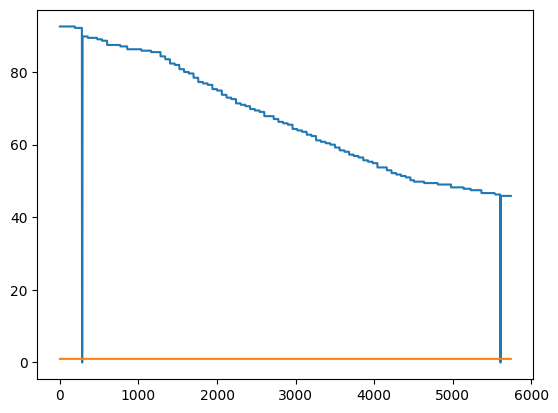

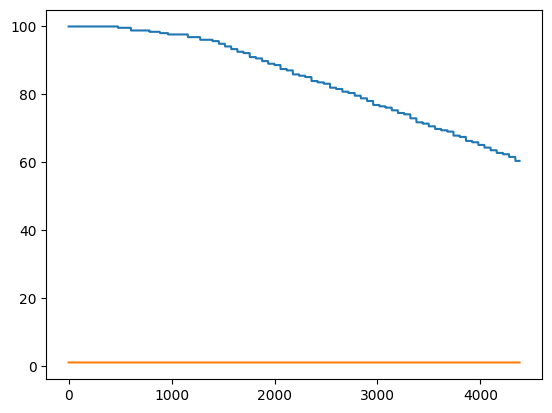

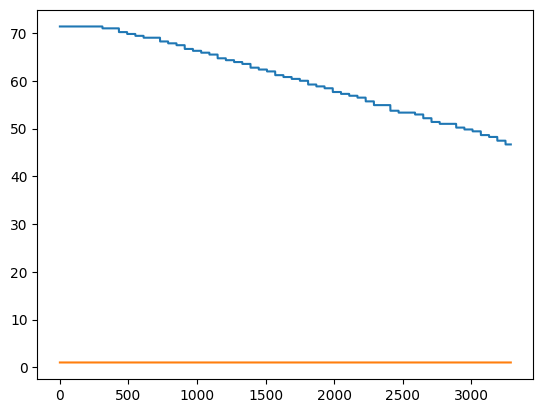

In [40]:
y = []
y_hat = []

for (inputsnp, targetsnp) in all_chunks:
    with torch.no_grad():
        inputs = torch.from_numpy((inputsnp - means) / stds).float().unsqueeze(0).cuda()
        targets = torch.from_numpy(targetsnp).float().unsqueeze(0).cuda()
        outputs = model(inputs).cpu().numpy()[0]
        plt.plot(targetsnp[:, 0])
        plt.plot(outputs[:, 0])
        y.append(targetsnp[:, 0])
        y_hat.append(outputs[:, 0])
        plt.show()


In [ ]:
import math
total_rmse_test = 0
for x_idx, i in enumerate(y):
  mse_test = 0
  for y_idx, j in enumerate(i):
    mse_test += ((y_hat[x_idx][y_idx] - j)**2)
  mse_test /= i.shape[0]
  total_rmse_test += mse_test
  rmse_test = math.sqrt(mse_test)
  print("Plot", x_idx, "RMSE = ", rmse_test)
total_rmse_test /= len(y)
total_rmse_test = math.sqrt(total_rmse_test)
print("Total RMSE: ", total_rmse_test)

Plot 0 RMSE =  0.022166897093506728
Plot 1 RMSE =  0.021755480215089426
Plot 2 RMSE =  0.019330170859224515
Plot 3 RMSE =  0.020010029142586542
Plot 4 RMSE =  0.017482035226286333
Plot 5 RMSE =  0.014972221540593902
Plot 6 RMSE =  0.012212987270235589
Plot 7 RMSE =  0.01363626091312586
Plot 8 RMSE =  0.020411818577453777
Plot 9 RMSE =  0.014948147184501222
Plot 10 RMSE =  0.02072011616779066
Plot 11 RMSE =  0.020733835100420175
Plot 12 RMSE =  0.017998571987196208
Plot 13 RMSE =  0.018256696810420168
Plot 14 RMSE =  0.013456528044099685
Plot 15 RMSE =  0.013011054333406272
Plot 16 RMSE =  0.01532671937840275
Plot 17 RMSE =  0.009562903613673499
Plot 18 RMSE =  0.011160604752246823
Plot 19 RMSE =  0.012545461683562728
Plot 20 RMSE =  0.016446598941551017
Plot 21 RMSE =  0.010954743185697696
Plot 22 RMSE =  0.010643769364568135
Plot 23 RMSE =  0.009963792768370502
Plot 24 RMSE =  0.0113199297142882
Plot 25 RMSE =  0.013917846999047164
Plot 26 RMSE =  0.01366999695360165
Plot 27 RMSE =  0

Test Model

In [ ]:
#val_chunks = extract_mat_file_chunks(["n10degC_LA92_Pan18650PF.mat"])

In [ ]:
#for (inputsnp, targetsnp) in val_chunks:
  #  with torch.no_grad():
   #     inputs = torch.from_numpy((inputsnp - means) / stds).float().unsqueeze(0).cuda()
   #     targets = torch.from_numpy(targetsnp).float().unsqueeze(0).cuda()
    #    outputs = model(inputs).cpu().numpy()[0]
    #    plt.plot(targetsnp[:, 0])
    #    plt.plot(outputs[:, 0])
    #    plt.show()